# Selección de portafolios usando simulación Montecarlo

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

> Durante el curso, específicamente en los módulos dos y tres, elaboramos toda la fundamentación de la teoría moderna de portafolios de Markowitz. Ésta se basa en la existencia de una línea especial en el espacio de rendimiento esperado vs. volatilidad, llamada **frontera de mínima varianza**.

> Al finalizar el módulo 3, vimos que no importa la cantidad de activos riesgosos que se tengan, si encontramos dos portafolios sobre la frontera eficiente, podemos reconstruirla. Dos portafolios importantes que hallamos en el curso fueron:

> - **Portafolio de mínima varianza**: minimizando la varianza.
> - **Portafolio eficiente en media varianza**: maximizando el radio de Sharpe.

> Por otra parte, resolver problemas de optimización cuando la cantidad de variables crece, se vuelve un problema complejo, computacionalmente hablando. Así que desarrollar métodos alternativos a la optimización que nos permitan encontrar los anteriores portafolios es de gran interés...

## 1. Descargamos activos de la BMV

Por simplicidad, y para entender las ideas alrededor de la selección de portafolios usando simulación montecarlo, utilizaremos únicamente tres activos de la BMV: Cemex, Grupo Carso y Grupo Financiero Banorte.

1.1. Descargar precios mensuales ajustados en el cierre para los tres activos mencionados anteriormente en los últimos 5 años:

In [1]:
# Importar librerías
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [4]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None, freq='m'):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.YahooDailyReader(symbols=tickers, start=start_date, end=end_date, interval=freq).read()['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

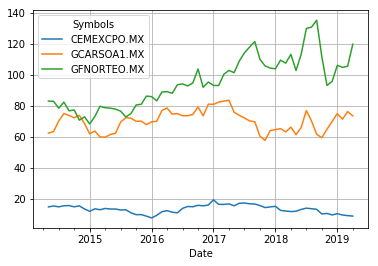

In [5]:
# Descargar precios y graficar
closes = get_adj_closes(['CEMEXCPO.MX', 'GFNORTEO.MX', 'GCARSOA1.MX'],
                        start_date='2014-05-01',
                        end_date='2019-04-01')
closes.plot(grid=True)

1.2. A partir de los precios, obtener los rendimientos mensuales:

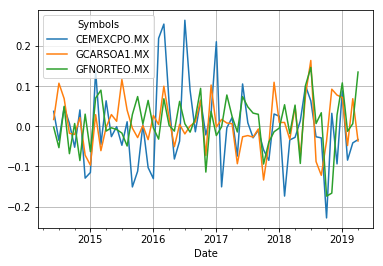

In [6]:
# Obtener rendimientos mensuales y graficar
ret = closes.pct_change().dropna()
ret.plot(grid=True)

1.3. Finalmente, a partir de los rendimientos mensuales, estimar la tendencia central de los rendimientos (rendimiento esperado), y caracterizar el riesgo de los activos (varianzas y covarianzas)

In [7]:
# Resumen: rendimiento medio mensual y volatilidad
summary = pd.DataFrame({'RE':ret.mean(), 'Vol':ret.std()})
summary

,RE,Vol
Symbols,,
CEMEXCPO.MX,-0.004066,0.098554
GCARSOA1.MX,0.004701,0.062409
GFNORTEO.MX,0.008336,0.064778


In [9]:
# Matriz de covarianza
cov = ret.cov()
cov

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Symbols,,,
CEMEXCPO.MX,0.009713,0.001986,0.001161
GCARSOA1.MX,0.001986,0.003895,0.001011
GFNORTEO.MX,0.001161,0.001011,0.004196


In [11]:
# Matriz de correlación
corr = ret.corr()
corr

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Symbols,,,
CEMEXCPO.MX,1.000000,0.322830,0.181914
GCARSOA1.MX,0.322830,1.000000,0.250108
GFNORTEO.MX,0.181914,0.250108,1.000000


___
## 2. Selección de portafolios mediante montecarlo

Antes de continuar, consultamos la tasa libre de riesgo al día de hoy en [Banxico](http://www.banxico.org.mx/):

In [12]:
# Tasa libre de riesgo
rf = 0.082/12

In [13]:
rf

0.006833333333333334

¿Alguien tiene alguna idea de lo que es simulación montecarlo?

En cuanto a la selección de portafolios, lo que hacemos es simular una gran cantidad de posibles portafolios que se pueden construir con los activos dados (generamos muchas ponderaciones posibles), y calculamos su rendimiento esperado y volatilidad para dibujarlos, y así poder identificar objetos de interés:

- frontera eficiente;
- portafolio de mínima varianza;
- portafolio EMV...

In [42]:
# Definimos el número de portafolios que simularemos, y la cantidad de activos que tenemos
n_port = 10000
n_act = summary.shape[0]

2.1. Generamos los portafolios

In [43]:
# Generar una matriz de pesos de n_port x n_act, tal que cada fila sume uno (recordar restricción)
w = np.random.random((n_port, n_act))
w /= w.sum(axis=1, keepdims=True)
#w#.sum(axis=1)

In [44]:
# Rendimientos y volatilidad de cada portafolios
Er = w.dot(summary['RE'])
s = np.sqrt((w.dot(cov).dot(w.T)).diagonal())

In [45]:
# Radio de Sharpe
SR = (Er-rf)/s

In [46]:
# Data frame de resultados
resultados = pd.DataFrame({'RE':Er,
                           'Vol': s,
                           'SR': SR,
                           'Cemex': w[:,0],
                           'GCarso': w[:,1],
                           'Banorte': w[:,2]})
resultados

,RE,Vol,SR,Cemex,GCarso,Banorte
0,0.000542,0.065065,-0.096694,0.479567,0.507933,0.012500
1,0.002891,0.058668,-0.067199,0.413000,0.088837,0.498163
2,0.003346,0.052756,-0.066094,0.303262,0.337906,0.358832
3,0.002526,0.055141,-0.078115,0.346888,0.414783,0.238329
4,0.002938,0.053632,-0.072622,0.311247,0.422909,0.265844
5,0.000393,0.066475,-0.096877,0.570003,0.240236,0.189762
6,0.005761,0.049486,-0.021666,0.086723,0.412401,0.500876
7,0.002437,0.055518,-0.079189,0.359107,0.397605,0.243288
8,0.002160,0.060257,-0.077556,0.462158,0.122173,0.415669
9,0.002522,0.055902,-0.077119,0.382905,0.292941,0.324153


2.2. Aproximar portafolio de mínima varianza y portafolio eficiente en media varianza

In [47]:
# Portafolio EMV
EMV = resultados.loc[resultados['SR'].idxmax()]

In [48]:
# Portafolio mínima varianza
min_var = resultados.loc[resultados['Vol'].idxmin()]

2.3. Dibujar todos los portafolios en el espacio de rendimiento esperado vs. volatilidad

(0, 0.01)

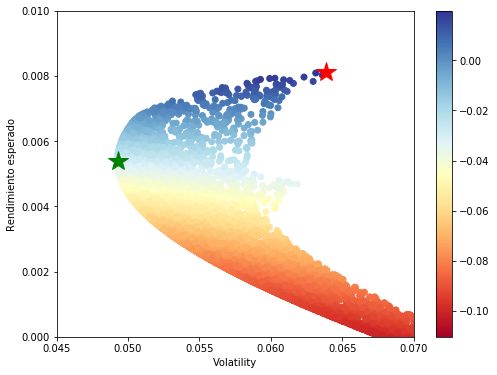

In [51]:
# Gráfica
plt.figure(figsize=(8,6))
plt.scatter(resultados['Vol'], 
            resultados['RE'], 
            c=resultados['SR'],
            cmap='RdYlBu'
           )
plt.colorbar()
plt.xlabel('Volatility')
plt.ylabel('Rendimiento esperado')
# EMV
plt.plot(EMV['Vol'], EMV['RE'], '*r', ms=20)
# Min var
plt.plot(min_var['Vol'], min_var['RE'], '*g', ms=20)
plt.xlim([0.045, 0.07])
plt.ylim([0, 0.01])

## 3. Comparar con los resultados obtenidos por optimización

3.1. Portafolio de mínima varianza

In [52]:
# Importamos funcion minimize del modulo optimize de scipy
import scipy.optimize as opt

In [53]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza
Sigma = cov
# 2. Eind: rendimientos esperados activos individuales
Eind = summary['RE']

In [54]:
# Función objetivo
def var(w, Sigma):
    return w.dot(Sigma).dot(w)

In [55]:
# Dato inicial
n = len(Eind)
w0 = np.ones((n,))/n
# Cotas de las variables
bnds = ((0,1),)*n
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: np.sum(w)-1}

In [56]:
# Portafolio de mínima varianza
min_var_opt = opt.minimize(var, w0, args=(Sigma,), bounds=bnds, constraints=cons)
min_var_opt

     fun: 0.0024305549185730246
     jac: array([0.00487183, 0.00472584, 0.00498575])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.1073575 , 0.43249439, 0.46014811])

In [57]:
# Comparar
min_var

RE         0.005381
Vol        0.049272
SR        -0.029479
Cemex      0.104032
GCarso     0.457981
Banorte    0.437987
Name: 1233, dtype: float64

3.2. Portafolio EMV

In [58]:
# Función objetivo
def m_sharpe(w, Sigma, rf, Eind):
    Erp = Eind.dot(w)
    sp = np.sqrt(w.dot(Sigma).dot(w))
    return -(Erp - rf)/sp

In [59]:
# Dato inicial
n = len(Eind)
w0 = np.ones((n,))/n
# Cotas de las variables
bnds = ((0,1),)*n
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: np.sum(w)-1}

In [60]:
# Portafolio EMV
EMV_opt = opt.minimize(m_sharpe, w0, args=(Sigma, rf, Eind), bounds=bnds, constraints=cons)
EMV_opt

     fun: -0.023193517355820967
     jac: array([ 0.06918734, -0.06697872, -0.10548793])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.00000000e+00, 9.99200722e-16, 1.00000000e+00])

In [61]:
# Comparar
EMV

RE         0.008104
Vol        0.063888
SR         0.019894
Cemex      0.018318
GCarso     0.001176
Banorte    0.980506
Name: 7841, dtype: float64

# Conclusión

- Tenemos una herramienta para aproximar toda la teoría de Markowitz.

- Esta herramienta no involucra optimización, solo generar números aleatorios normalizados.

- Por tanto, no le afecta el problema de dimensión (cuando tenemos muchos activos).

## Esto lo usarán en la actividad en conjunto con las demás herramientas vistas en el módulo 3 (LAC, distribución óptima de capital).

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>